In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from math import sqrt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

### Degraded image from Dataset

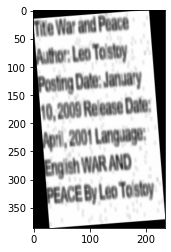

In [2]:
path = '../../StandartImages/Train/DegradedImages/degraded_image0.png'
image = cv.imread(path)
image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

plt.imshow(image, cmap='gray')
plt.show()

In [3]:
def rotate_and_cut_off(image: np.array, angle: float, center: (int, int)) -> np.array:
    """
        Function rotates an image and cuts off black borders

        Args:
            image (np.array): tensor representing an image.
            angle (float): the angle of rotation is measured in degrees.
            center ((int, int)): center of rotation.
    """
    height, width = image.shape[:2]
    x, y = center

    theta = angle / 180.0 * np.math.pi
    cos_t = np.math.cos(theta)
    sin_t = np.math.sin(theta)
    M = np.float32([[cos_t, sin_t, x - x * cos_t - y * sin_t], [-sin_t, cos_t, y + x * sin_t - y * cos_t]])

    new_width = int(-height * np.abs(sin_t) + width * cos_t)
    new_height = int(height * cos_t - width * np.abs(sin_t))

    M[0, 2] += (new_width / 2) - x
    M[1, 2] += (new_height / 2) - y

    rotated = cv.warpAffine(image, M, (new_width, new_height))
    return rotated

In [4]:
def make_image_horizontal(image: np.array, max_angle=5) -> np.array:
    """
        Function rotates an image to make its text horizontal

        Args:
            image (np.array): tensor representing an image.
            max_angle (float): the max rotating angle to find the horizontal position
    """
    height, width = image.shape[:2]

    max_variation = 0
    best_angle = None

    for angle in np.linspace(-max_angle, max_angle, 21):
        M = cv.getRotationMatrix2D((width // 2, height // 2), angle, 1)
        rotated_img = cv.warpAffine(image, M, (width, height))

        x = [sum(1 - row / 255) for row in rotated_img]
        x_mean = sum(x) / len(x)
        x_RMSE = sqrt(sum((x - x_mean)**2) / len(x))
        x_variation = x_RMSE / x_mean

        if x_variation > max_variation:
            best_angle = angle
            max_variation = x_variation

    horizontal_img = rotate_and_cut_off(image, best_angle, (width // 2, height // 2))
    return horizontal_img[2:-2]

### Horizontal image

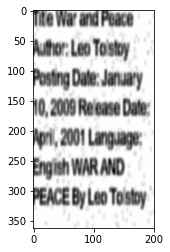

In [5]:
image = make_image_horizontal(image)

plt.imshow(image, cmap='gray')
plt.show()

In [12]:
def cut_image_into_text_lines(image: np.array, valley_coef=0.04, slope_coef=0.02, deviation_bound=0.3, show_plot=False):
    """
        Function cuts an multi-line image to list of single-line images

        Args:
            image (np.array): tensor representing an image.
            valley_coef (float): relative height of areas of the image where few black pixels are
            slope_coef (float): relative height of areas of the image where number of black pixels starts to increase
            deviation_bound (float): hyperparameter that regulates the increase in number of black pixels where text appears
    """
    image = make_image_horizontal(image)

    height, width = image.shape[:2]
    valley_size = int(height * valley_coef)
    slope_size = int(height * slope_coef)

    x = [sum(1 - row / 255) for row in image]

    x_mean = sum(x) / len(x)
    x_RMSE = sqrt(sum((x - x_mean) ** 2) / len(x))

    prev_cut_index = -1
    cut_indices = [0]
    for i in range(valley_size + slope_size, len(x) - valley_size):
        maybe_valley = x[i - valley_size: i]
        mean = sum(maybe_valley) / len(maybe_valley)
        derivation = (sum(x[i: i + slope_size]) - sum(x[i - slope_size: i])) / slope_size

        if mean < x_mean - x_RMSE / 2 and derivation / x_RMSE > deviation_bound:
            if prev_cut_index == -1 or i - prev_cut_index > valley_size:
                cut_indices.append(i)
                prev_cut_index = i
                if show_plot:
                    plt.plot([i, i], [0, 100], 'k--')
            else:
                if show_plot:
                    plt.plot([i, i], [0, 100], 'r-')
    cut_indices.append(height)

    if show_plot:
        plt.plot([i for i in range(len(x))], x)
        plt.show()
    
    single_line_images = []
    for j in range(len(cut_indices) - 1):
        single_line_images.append(image[cut_indices[j]: cut_indices[j + 1]])

    return single_line_images

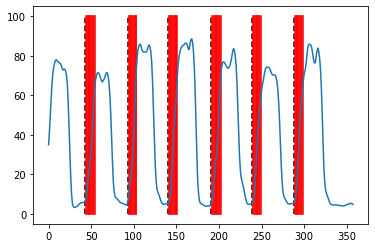

In [13]:
single_line_images = cut_image_into_text_lines(image, show_plot=True)

### Single-line images

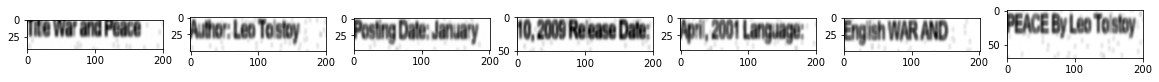

In [39]:
_, ax = plt.subplots(1, 7, figsize=(20, 5))
for i in range(len(single_line_images)):
    ax[i].imshow(single_line_images[i], cmap="gray")
plt.show()